In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## In order to check the performance of the proposed Network Architecture in GPU and long epoches, I compile it on pytroch, And See what it will like 

In [2]:
# Hyper-parameters
num_epochs = 80
batch_size = 100
learning_rate = 0.001

# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

In [3]:
# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',train=True,transform=transform,
                      download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',train=False,transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,
                       shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,
                      shuffle=False)

# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)
    


Extracting ../../data/cifar-10-python.tar.gz to ../../data/


In [4]:
# Basic Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


In [6]:
# ResNet
class LiuZihuaNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(LiuZihuaNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    


In [7]:
model = LiuZihuaNet(ResidualBlock, [2, 3, 4]).to(device)

# Training the Cifar-10 Model with Adma and a learning rate decay

## Network: LiuZihuaNet: ( A designed Resnet)
### Configs: Learning Rate: 1e-3  
### Optimizer : Adam
### Batch size :100  
### Epoch: 80


In [8]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)


Epoch [1/80], Step [100/500] Loss: 1.6069
Epoch [1/80], Step [200/500] Loss: 1.4879
Epoch [1/80], Step [300/500] Loss: 1.3060
Epoch [1/80], Step [400/500] Loss: 1.1139
Epoch [1/80], Step [500/500] Loss: 1.0674
Epoch [2/80], Step [100/500] Loss: 0.9628
Epoch [2/80], Step [200/500] Loss: 1.0018
Epoch [2/80], Step [300/500] Loss: 0.9823
Epoch [2/80], Step [400/500] Loss: 0.9589
Epoch [2/80], Step [500/500] Loss: 1.0256
Epoch [3/80], Step [100/500] Loss: 0.8323
Epoch [3/80], Step [200/500] Loss: 0.6909
Epoch [3/80], Step [300/500] Loss: 0.8543
Epoch [3/80], Step [400/500] Loss: 0.7159
Epoch [3/80], Step [500/500] Loss: 0.7087
Epoch [4/80], Step [100/500] Loss: 0.8465
Epoch [4/80], Step [200/500] Loss: 0.8009
Epoch [4/80], Step [300/500] Loss: 0.7669
Epoch [4/80], Step [400/500] Loss: 0.7523
Epoch [4/80], Step [500/500] Loss: 0.7492
Epoch [5/80], Step [100/500] Loss: 0.6324
Epoch [5/80], Step [200/500] Loss: 0.8723
Epoch [5/80], Step [300/500] Loss: 0.6142
Epoch [5/80], Step [400/500] Loss:

Epoch [39/80], Step [300/500] Loss: 0.1315
Epoch [39/80], Step [400/500] Loss: 0.1392
Epoch [39/80], Step [500/500] Loss: 0.2498
Epoch [40/80], Step [100/500] Loss: 0.1317
Epoch [40/80], Step [200/500] Loss: 0.1682
Epoch [40/80], Step [300/500] Loss: 0.0895
Epoch [40/80], Step [400/500] Loss: 0.0861
Epoch [40/80], Step [500/500] Loss: 0.1789
Epoch [41/80], Step [100/500] Loss: 0.1461
Epoch [41/80], Step [200/500] Loss: 0.1742
Epoch [41/80], Step [300/500] Loss: 0.1003
Epoch [41/80], Step [400/500] Loss: 0.2002
Epoch [41/80], Step [500/500] Loss: 0.1934
Epoch [42/80], Step [100/500] Loss: 0.1314
Epoch [42/80], Step [200/500] Loss: 0.1055
Epoch [42/80], Step [300/500] Loss: 0.1074
Epoch [42/80], Step [400/500] Loss: 0.0572
Epoch [42/80], Step [500/500] Loss: 0.1211
Epoch [43/80], Step [100/500] Loss: 0.1101
Epoch [43/80], Step [200/500] Loss: 0.0898
Epoch [43/80], Step [300/500] Loss: 0.0362
Epoch [43/80], Step [400/500] Loss: 0.1156
Epoch [43/80], Step [500/500] Loss: 0.1135
Epoch [44/8

Epoch [77/80], Step [400/500] Loss: 0.0435
Epoch [77/80], Step [500/500] Loss: 0.0172
Epoch [78/80], Step [100/500] Loss: 0.1111
Epoch [78/80], Step [200/500] Loss: 0.1077
Epoch [78/80], Step [300/500] Loss: 0.0376
Epoch [78/80], Step [400/500] Loss: 0.0483
Epoch [78/80], Step [500/500] Loss: 0.0456
Epoch [79/80], Step [100/500] Loss: 0.1257
Epoch [79/80], Step [200/500] Loss: 0.1064
Epoch [79/80], Step [300/500] Loss: 0.0317
Epoch [79/80], Step [400/500] Loss: 0.0633
Epoch [79/80], Step [500/500] Loss: 0.0487
Epoch [80/80], Step [100/500] Loss: 0.0738
Epoch [80/80], Step [200/500] Loss: 0.0496
Epoch [80/80], Step [300/500] Loss: 0.0530
Epoch [80/80], Step [400/500] Loss: 0.0588
Epoch [80/80], Step [500/500] Loss: 0.0235


In [9]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'liuzihua_net.ckpt')

Accuracy of the model on the test images: 89.43 %


## As we can seen, By using designed Liuzihua Net, the accuracy of testing image on Cifar-10 can be improved to 89.43%

In [22]:
# Test the model
model.eval()
predicted_result_list = []
gt_result_list= []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predict_array = predicted.cpu().numpy()
        predicted_result_list.extend(predict_array)
        gt_label =labels.cpu().numpy()
        gt_result_list.extend(gt_label)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(len(predicted_result_list))
print(len(gt_result_list))

10000
10000


In [24]:
import sklearn.metrics
acc = sklearn.metrics.accuracy_score(gt_result_list,predicted_result_list)

In [25]:
acc

0.8943

In [33]:
# get confusion matrix
def plot_confusion_matrix(cm, labels_name, title,figname):
    plt.figure(figsize=(10,10))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    # 归一化
    plt.imshow(cm, interpolation='nearest')    # 在特定的窗口上显示图像
    plt.title(title)    # 图像标题
    plt.colorbar()
    num_local = np.array(range(len(labels_name)))    
    plt.xticks(num_local, labels_name, rotation=90)    # 将标签印在x轴坐标上
    plt.yticks(num_local, labels_name)    # 将标签印在y轴坐标上
    plt.ylabel('GT label')    
    plt.xlabel('Predicted label')
    plt.savefig(figname, format='png')
    plt.show()

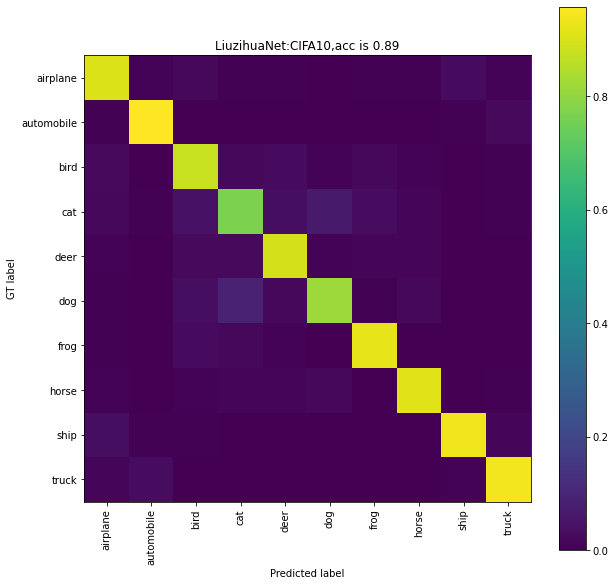

In [34]:
import numpy as np
import matplotlib.pyplot as plt
labels_name =["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
confusion_matrix = sklearn.metrics.confusion_matrix(gt_result_list,predicted_result_list)
plot_confusion_matrix(cm = confusion_matrix,labels_name=labels_name,title="LiuzihuaNet:CIFA10,acc is {}" .format(round(acc,2)), figname="LIUZIHA")

In [55]:
# Visualization
vis_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=1,
                      shuffle=False)
model.eval()
visuilzation_images = []
predict_labels = []
gt_labels = []

with torch.no_grad():
    correct = 0
    total = 0
    cnt =0
    for images, labels in vis_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        predict_array = predicted.cpu().numpy()
        
        gt_label =labels.cpu().numpy()
        
        vis_image = images.squeeze(0)
        vis_image = vis_image.permute(2,1,0)
        vis_image = vis_image.cpu().numpy()
        
        visuilzation_images.append(vis_image)
        predict_labels.append(predict_array[0])
        gt_labels.append(gt_label[0])
        
        cnt = cnt+1
        if cnt>19:
            break

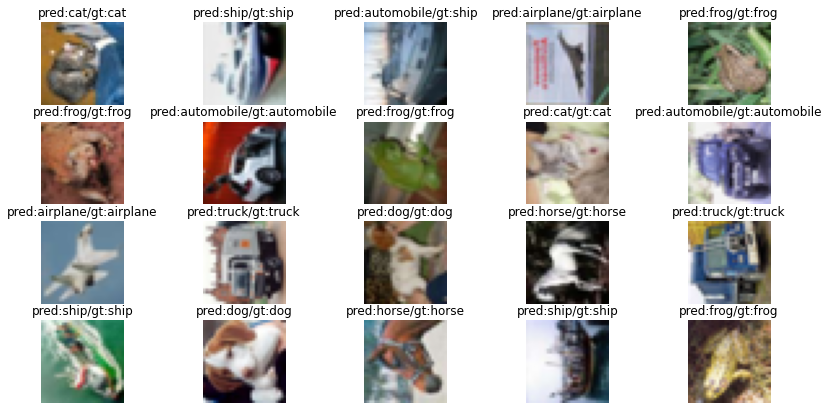

In [65]:
plt.figure(figsize=(14,7))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.title("pred:{}/gt:{}".format(labels_name[predict_labels[i]],labels_name[gt_labels[i]]))
    plt.axis("off")
    plt.imshow(visuilzation_images[i])
plt.show()
